# Wine Quality Regression
A machine learning attempt at predicting wine quality ratings using dataset from the University of Massachusetts

# Load Modules

In [30]:
import numpy as np # for array operations
import pandas as pd # for graphical display of arrays (basically arrays with row and column names)
import seaborn as sns # for plotting graphs
from matplotlib import pyplot as plt # for customizing graphs
%matplotlib inline
# IPython Notebook function, just ignore

from sklearn.model_selection import train_test_split # split data
from sklearn import preprocessing # for scaling
from sklearn.pipeline import make_pipeline # for grouping scaler and model into a wrapper called pipeline, goes into GridSearch
from sklearn.model_selection import GridSearchCV # for cross-validation, determines best hyperparameters
from sklearn.metrics import mean_squared_error, r2_score # performance measures
from sklearn.externals import joblib #for saving model

Just to suppress the warnings sklearn gives:

In [31]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Also, for clarity, make numpy print arrays to 2 decimal places

In [32]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# Load Dataset
We load the dataset into variable data:

In [33]:
# dataset_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
dataset_url = './wine-quality-red.csv'
data = pd.read_csv(dataset_url, sep = ";")

# Data Preview
We'll first try to get familiar with how the dataset is structured

In [34]:
print("Data dimensions: "+ str(data.shape) +"\n")

print("The first entries of the dataset: ")
data.head()

print("\nQuantitative properties of each feature: ")
data.describe()

Data dimensions: (1599, 12)

The first entries of the dataset: 


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5



Quantitative properties of each feature: 


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


We see that the magnitudes of the features are drastically different, later we'll have to standardize the features before we perform any sort of optimization


# Feature Selection
Notice that the Quality column of data is the desired value that we wish to predict. So we split data into X (the features) and y (Quality). 

As we're trying to predict the value of y, it's only natural that we'd want to get to know y better 

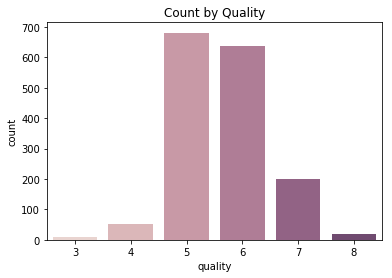

In [35]:
y = data['quality']
X = data.drop(['quality'], axis = 1)

sns.countplot(y, palette = sns.cubehelix_palette(8)).set_title('Count by Quality');

Quality has a distribution that is approximately normal, however, due to the few data collected for quality below 3 and above 8, it may be hard to predict those values. When we train the model later, we'll remember to use different weights for the classes inversely proportional to their frequency.

Now, we split the data into our test-set and training-set using train_test_split from from sklearn.model_selection

In [36]:
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 817, stratify = y)
X_train = train_data.drop(['quality'], axis = 1)
X_test = test_data.drop(['quality'], axis = 1)
y_train = train_data['quality']
y_test = test_data['quality']

print("X_train dimensions: ", X_train.shape)
print("X_test dimensions: ", X_test.shape)
print("Test set proportion: %.2f" % (X_test.shape[0]/(X_test.shape[0] + X_train.shape[0])))
print("\nX_train: ")
X_train.head()

df_y_train = pd.DataFrame(y_train, columns=['quality'])
df_y_train.head()

X_train dimensions:  (1279, 11)
X_test dimensions:  (320, 11)
Test set proportion: 0.20

X_train: 


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
797,9.3,0.37,0.44,1.6,0.038,21.0,42.0,0.99526,3.24,0.81,10.8
1386,7.4,0.64,0.07,1.8,0.100,8.0,23.0,0.99610,3.30,0.58,9.6
40,7.3,0.45,0.36,5.9,0.074,12.0,87.0,0.99780,3.33,0.83,10.5
433,12.3,0.39,0.63,2.3,0.091,6.0,18.0,1.00040,3.16,0.49,9.5
874,10.4,0.38,0.46,2.1,0.104,6.0,10.0,0.99664,3.12,0.65,11.8


,quality
797,7
1386,5
40,5
433,5
874,7


# Standardization

To allow convienient graphing, we will now standardize our dataset

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nTraining set stats (note that mean is around 0 and std around 1) :")
X_train_scaled.describe()
print("\nTest set stats (note the deviation of mean from 0 and std from 1): ")
X_test_scaled.describe()


Training set stats (note that mean is around 0 and std around 1) :


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03
mean,5.874894e-16,2.178780e-16,1.197895e-17,-3.023003e-16,1.555093e-16,-1.170118e-16,6.341031e-17,3.557037e-14,4.408601e-15,-2.130170e-16,7.446914e-16
std,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00
min,-2.126191e+00,-2.289244e+00,-1.398924e+00,-1.136506e+00,-1.576773e+00,-1.426875e+00,-1.217252e+00,-3.471959e+00,-3.639059e+00,-1.955538e+00,-1.910806e+00
25%,-6.958022e-01,-7.763849e-01,-9.363400e-01,-4.468813e-01,-3.629695e-01,-8.516878e-01,-7.444271e-01,-5.872507e-01,-6.393366e-01,-6.418863e-01,-8.793918e-01
50%,-2.380776e-01,-4.797096e-02,-6.257001e-02,-2.399938e-01,-1.746207e-01,-1.806361e-01,-2.716019e-01,-1.343884e-02,-6.492170e-02,-2.239062e-01,-2.230370e-01
75%,5.629404e-01,6.244111e-01,7.598017e-01,3.585619e-02,5.558344e-02,4.904157e-01,4.671876e-01,5.760224e-01,5.733170e-01,4.329196e-01,6.208478e-01
max,4.339168e+00,5.891404e+00,3.740899e+00,8.932019e+00,1.095889e+01,5.379507e+00,7.145844e+00,3.632875e+00,4.466573e+00,8.016272e+00,4.183917e+00



Test set stats (note the deviation of mean from 0 and std from 1): 


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,0.010095,-0.020743,-0.030767,-0.031706,0.012813,-0.004485,-0.106759,0.054522,0.030016,0.019418,-0.069741
std,0.980664,1.016276,1.005836,0.851896,0.922160,1.013733,0.845762,0.918557,0.923915,1.059326,0.994140
min,-1.897329,-2.065117,-1.398924,-0.929619,-1.011727,-1.235146,-1.217252,-2.689489,-2.745524,-1.597269,-1.348217
25%,-0.638587,-0.776385,-0.897791,-0.446881,-0.342042,-0.755823,-0.744427,-0.524653,-0.575513,-0.701598,-0.879392
50%,-0.238078,-0.104003,-0.165366,-0.239994,-0.153693,-0.276501,-0.330705,0.090891,0.062726,-0.283618,-0.363684
75%,0.448509,0.624411,0.811200,0.035856,0.060815,0.490416,0.297266,0.591672,0.589273,0.492631,0.527083
max,3.824228,3.369971,2.455943,5.828707,7.945307,4.996049,2.890417,2.855620,4.466573,5.747237,2.964972


Note that we applied the standard scaler fitted by the training set on the test set as well, this is because we are not supposed to know anything about the test set

Now, on to analyzing the features for the learning algorithms:

First, let's look at the correlation between the variables and Quality


Since the value we're trying to classify is discrete, a scatterplot would not help much.

So, further data graphing (this is where standardization helped):

# Swarmplot

To modify our data into the format allowed by swarmplot, we use melt to transform the dataset

reindexing y_train to concat it with X_train_scaled:

In [38]:
print("y_train before re-indexing: ")
df_y_train.head()
print("y_train after re-indexing")
df_y_train.reset_index(drop=True, inplace=True)
df_y_train.head()
print("The concatenated train_data_scaled: ")
train_data_scaled = pd.concat([X_train_scaled, df_y_train], axis=1)
train_data_scaled.head()

y_train before re-indexing: 


,quality
797,7
1386,5
40,5
433,5
874,7


y_train after re-indexing


,quality
0,7
1,5
2,5
3,5
4,7


The concatenated train_data_scaled: 


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.562940,-0.888449,0.862598,-0.653769,-1.032654,0.490416,-0.153396,-0.764611,-0.447865,0.910611,0.339553,7
1,-0.524155,0.624411,-1.039136,-0.515844,0.264860,-0.755823,-0.714876,-0.326427,-0.064922,-0.462752,-0.785627,5
2,-0.581371,-0.440194,0.451412,2.311619,-0.279259,-0.372365,1.176425,0.560373,0.126550,1.030034,0.058258,5
3,2.279407,-0.776385,1.839165,-0.171031,0.076511,-0.947552,-0.862633,1.916656,-0.958456,-1.000155,-0.879392,5
4,1.192312,-0.832417,0.965395,-0.308956,0.348571,-0.947552,-1.099046,-0.044738,-1.213751,-0.044772,1.277203,7


Now, we melt the 11 specifications (previously X_train_scaled) into one large column called Stat Type

In [39]:
swarm_data = pd.melt(train_data_scaled, id_vars=["quality"], var_name="Stat Type")
swarm_data.head(10)

,quality,Stat Type,value
0,7,fixed acidity,0.562940
1,5,fixed acidity,-0.524155
2,5,fixed acidity,-0.581371
3,5,fixed acidity,2.279407
4,7,fixed acidity,1.192312
5,5,fixed acidity,-0.581371
6,6,fixed acidity,-1.153527
7,5,fixed acidity,0.391294
8,6,fixed acidity,-1.153527
9,5,fixed acidity,-0.581371


Note that the table is 11 times as long since the 11 features are all melted into 1 column.

The swarmplot:

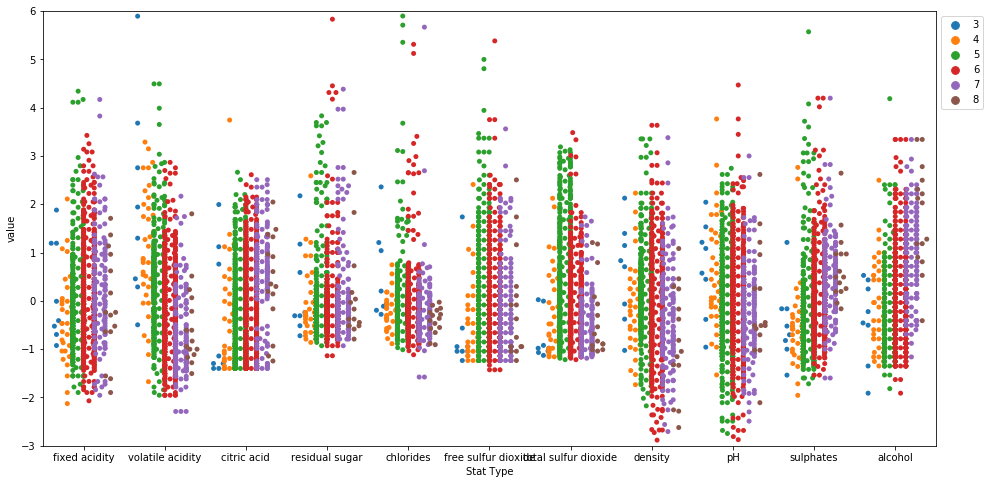

In [40]:
plt.figure(figsize=(16,8));
sns.swarmplot(x='Stat Type', y='value', hue='quality', data=swarm_data, dodge=True);
plt.ylim(-3, 6);
plt.legend(bbox_to_anchor=(1, 1), loc=2);

From the graph, there are no distinct separation (referring to vertical separation) between the overall quality, ie. it's not as simple as for example, higher acidity means higher quality. 

This could pose a threat to our model. We'll see how it goes.

# Heatmap

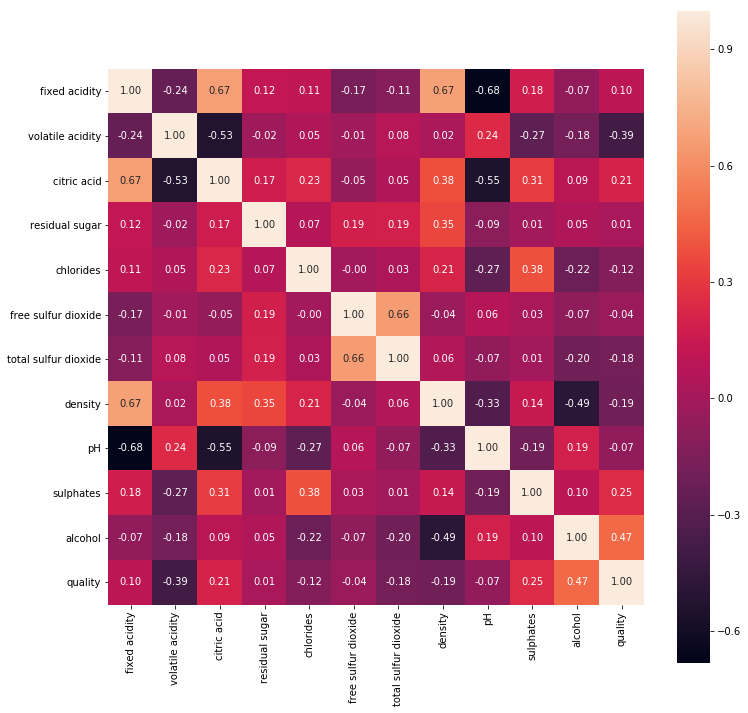

In [41]:
corrmat = train_data.corr()
plt.figure(figsize=(12,12));
sns.heatmap(corrmat, annot = True, square = True, fmt = '.2f');

Nothing too out of the ordinary here either. These features are fine, no risk of having multicollinearity.

# Random Forest

## Cross Validation with Gridsearch

In [42]:
from sklearn.ensemble import RandomForestRegressor

pipeline_rfr = make_pipeline(
    preprocessing.StandardScaler(),
    RandomForestRegressor(random_state = 111)
)

hyperparameters_rfr = {
    'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
    'randomforestregressor__n_estimators': [750, 1000, 1500],
    'randomforestregressor__min_samples_split': [2,4]
}

CV_rfr = GridSearchCV(pipeline_rfr, hyperparameters_rfr, cv=3)

CV_rfr.fit(X_train, y_train)
print("Best Parameters: ", CV_rfr.best_params_)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decr...timators=10, n_jobs=1,
           oob_score=False, random_state=111, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'], 'randomforestregressor__n_estimators': [750, 1000, 1500], 'randomforestregressor__min_samples_split': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Parameters:  {'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 1500}


## Grid Search Results
### Run 1:
```python
hyperparameters_rfr = {
    'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
    'randomforestregressor__n_estimators': [200, 500, 1000],
    'randomforestregressor__min_samples_split': [2,4,8]
}

Best Parameters:  {
    'randomforestregressor__max_features': 'sqrt', 
    'randomforestregressor__min_samples_split': 2, 
    'randomforestregressor__n_estimators': 1000
}

R2 score:  0.53691813790181
    
Forced Classification Scores:

    Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.736486	0.801471	0.767606	136
6	0.692308	0.773438	0.730627	128
7	0.758621	0.550000	0.637681	40
8	0.000000	0.000000	0.000000	3
```

### Run 2:
```python
hyperparameters_rfr = {
    'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
    'randomforestregressor__n_estimators': [750, 1000, 1500],
    'randomforestregressor__min_samples_split': [2,4]
}

Best Parameters:  {
    'randomforestregressor__max_features': 'sqrt', 
    'randomforestregressor__min_samples_split': 2, 
    'randomforestregressor__n_estimators': 1500
}

R2 score:  0.5376639543690431

    Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.726667	0.801471	0.762238	136
6	0.678322	0.757812	0.715867	128
7	0.740741	0.500000	0.597015	40
8	0.000000	0.000000	0.000000	3
```

## Final Model

In [43]:
CV_rfr = make_pipeline(
    preprocessing.StandardScaler(),
    RandomForestRegressor(
        max_features = 'sqrt',
        n_estimators = 1500,
        min_samples_split = 2
    )
)

CV_rfr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

## Performance

Actual Qualities: 


array([6, 5, 6, 5, 6, 6, 6, 6, 7, 7], dtype=int64)

Predicted Qualities: 


array([5.26, 5.08, 6.43, 4.96, 5.68, 5.73, 5.98, 5.56, 6.82, 6.81])

Forced Classification: 


array([5.00, 5.00, 6.00, 5.00, 6.00, 6.00, 6.00, 6.00, 7.00, 7.00])

R2 score:  0.5417572298565289
Forced Classification Scores:


Text(0.5,42,'Predicted')

Text(134.88,0.5,'Actual')

,Precision,Recall,F Score,Support
3,0.000000,0.000000,0.000000,2
4,0.000000,0.000000,0.000000,11
5,0.731544,0.801471,0.764912,136
6,0.685315,0.765625,0.723247,128
7,0.750000,0.525000,0.617647,40
8,0.000000,0.000000,0.000000,3


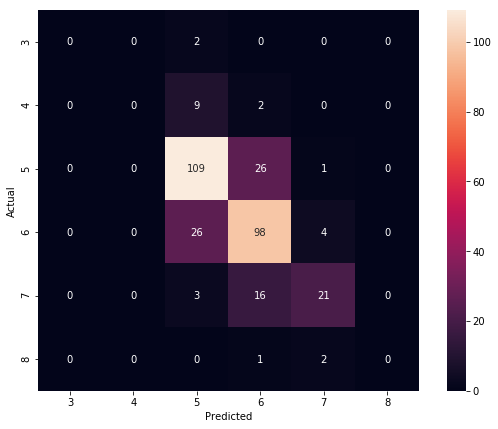

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import r2_score
y_pred_rfr = 0
y_pred_rfr = CV_rfr.predict(X_test)
print("Actual Qualities: ")
y_test.values[0:10]
print("Predicted Qualities: ")
y_pred_rfr[0:10]
print("Forced Classification: ")
y_pred_rfr_int = np.rint(y_pred_rfr)
y_pred_rfr_int[0:10]

print("R2 score: ", r2_score(y_test, y_pred_rfr))
print("Forced Classification Scores:")

cm = confusion_matrix(y_test, y_pred_rfr_int)
     
df_cm = pd.DataFrame(cm, range(3,9), range(3,9))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')


precision, recall, fscore, support = score(y_test, y_pred_rfr_int);

df_precision = pd.DataFrame(precision, index=range(3, 9), columns=["Precision"])
df_recall = pd.DataFrame(recall, index=range(3, 9), columns=["Recall"])
df_fscore = pd.DataFrame(fscore, index=range(3, 9), columns=["F Score"])
df_support = pd.DataFrame(support, index=range(3, 9), columns=["Support"])

score = pd.concat([df_precision, df_recall, df_fscore, df_support], axis = 1)
score

Here, we try a few more algorithms:

# SVM
## Cross Validation with Gridsearch

In [45]:
from sklearn.svm import SVR

pipeline_svr = make_pipeline(
    preprocessing.StandardScaler(), 
    SVR()
)

hyperparameters_svr = { 
    "svr__kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "svr__gamma" : [0.03, 0.1, 0.3],
    "svr__C" : [0.1, 0.3, 1]
}
 
CV_svr = GridSearchCV(pipeline_svr, hyperparameters_svr, cv= 3)

CV_svr.fit(X_train, y_train)
print("Best Parameters = ", CV_svr.best_params_)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'svr__gamma': [0.03, 0.1, 0.3], 'svr__C': [0.1, 0.3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Parameters =  {'svr__C': 1, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}


## Grid Search Results

### Run 1
```python
hyperparameters_svr = { 
    "svr__kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "svr__gamma" : [0.1, 0.001, 0.00001],
    "svr__C" : [3, 10, 30]
}

Best Parameters =  {
    'svr__C': 3, 
    'svr__gamma': 0.1, 
    'svr__kernel': 'rbf'
}

R2 score:  0.3845920812148286
    
	Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.696552	0.742647	0.718861	136
6	0.602837	0.664062	0.631970	128
7	0.593750	0.475000	0.527778	40
8	0.000000	0.000000	0.000000	3
```

### Run 2
```python
hyperparameters_svr = { 
    "svr__kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "svr__gamma" : [0.03, 0.1, 0.3],
    "svr__C" : [1, 3, 5]
}

Best Parameters =  {
    'svr__C': 1, 
    'svr__gamma': 0.1, 
    'svr__kernel': 'rbf'
}

R2 score:  0.4060408127341305
    
Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.681529	0.786765	0.730375	136
6	0.594203	0.640625	0.616541	128
7	0.600000	0.375000	0.461538	40
8	0.000000	0.000000	0.000000	3
```
### Run 3 (no change)
```python
hyperparameters_svr = { 
    "svr__kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "svr__gamma" : [0.03, 0.1, 0.3],
    "svr__C" : [0.1, 0.3, 1]
}

Best Parameters =  {
    'svr__C': 1, 
    'svr__gamma': 0.1, 
    'svr__kernel': 'rbf'
}

R2 score:  0.4060408127341305
    
Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.681529	0.786765	0.730375	136
6	0.594203	0.640625	0.616541	128
7	0.600000	0.375000	0.461538	40
8	0.000000	0.000000	0.000000	3
```

svr is maxed out as well.

## Final model:

In [46]:
CV_svr = make_pipeline(
    preprocessing.StandardScaler(), 
    SVR(
        C = 1, 
        gamma = 0.1, 
        kernel = 'rbf'
    )
)

CV_svr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

## Performance: 

Actual Qualities: 


array([6, 5, 6, 5, 6, 6, 6, 6, 7, 7], dtype=int64)

Predicted Qualities: 


array([5.20, 5.10, 6.78, 5.07, 5.84, 5.85, 6.03, 5.59, 6.74, 6.75])

Forced Classification: 


array([5.00, 5.00, 7.00, 5.00, 6.00, 6.00, 6.00, 6.00, 7.00, 7.00])

R2 score:  0.4060408127341305
Forced Classification Scores:


Text(0.5,42,'Predicted')

Text(134.88,0.5,'Actual')

,Precision,Recall,F Score,Support
3,0.000000,0.000000,0.000000,2
4,0.000000,0.000000,0.000000,11
5,0.681529,0.786765,0.730375,136
6,0.594203,0.640625,0.616541,128
7,0.600000,0.375000,0.461538,40
8,0.000000,0.000000,0.000000,3


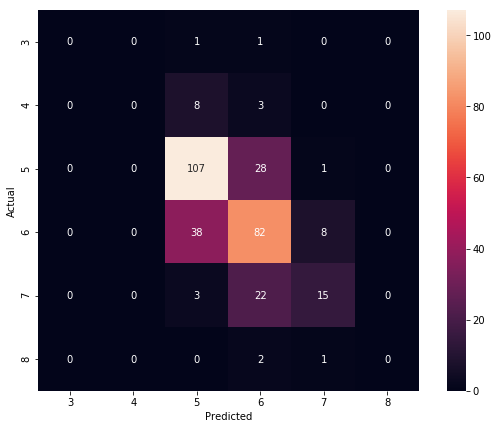

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import r2_score

y_pred_svr = 0
y_pred_svr = CV_svr.predict(X_test)
print("Actual Qualities: ")
y_test.values[0:10]
print("Predicted Qualities: ")
y_pred_svr[0:10]
print("Forced Classification: ")
y_pred_svr_int = np.rint(y_pred_svr)
y_pred_svr_int[0:10]

print("R2 score: ", r2_score(y_test, y_pred_svr))
print("Forced Classification Scores:")

cm = confusion_matrix(y_test, y_pred_svr_int)
     
df_cm = pd.DataFrame(cm, range(3,9), range(3,9))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')


precision, recall, fscore, support = score(y_test, y_pred_svr_int);

df_precision = pd.DataFrame(precision, index=range(3, 9), columns=["Precision"])
df_recall = pd.DataFrame(recall, index=range(3, 9), columns=["Recall"])
df_fscore = pd.DataFrame(fscore, index=range(3, 9), columns=["F Score"])
df_support = pd.DataFrame(support, index=range(3, 9), columns=["Support"])

score = pd.concat([df_precision, df_recall, df_fscore, df_support], axis = 1)
score

Now let's another algorithm: Neural Network

Hopefully it would give us better results

# Neural Network
## Cross Validation with Gridsearch

In [48]:
from sklearn.neural_network import MLPRegressor

pipeline_nn = make_pipeline(
    preprocessing.StandardScaler(), 
    MLPRegressor(max_iter=1000)
)

hyperparameters_nn = {
    'mlpregressor__learning_rate': ["constant", "invscaling", "adaptive"],
    'mlpregressor__hidden_layer_sizes': [(15), (20), (25)],
    'mlpregressor__alpha': [0.03, 0.1, 0.3],
    'mlpregressor__activation': ['logistic', 'tanh', 'relu']
}

CV_nn = GridSearchCV(pipeline_nn, hyperparameters_nn, cv=3)

CV_nn.fit(X_train, y_train)
print("Best Parameters = ", CV_nn.best_params_)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlpregressor', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
   ...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'mlpregressor__learning_rate': ['constant', 'invscaling', 'adaptive'], 'mlpregressor__hidden_layer_sizes': [15, 20, 25], 'mlpregressor__alpha': [0.03, 0.1, 0.3], 'mlpregressor__activation': ['logistic', 'tanh', 'relu']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Parameters =  {'mlpregressor__activation': 'tanh', 'mlpregressor__alpha': 0.3, 'mlpregressor__hidden_layer_sizes': 20, 'mlpregressor__learning_rate': 'constant'}


## GridSearch Results
### Run 1:
```python
hyperparameters_nn = {
    'mlpregressor__learning_rate': ["constant", "invscaling", "adaptive"],
    'mlpregressor__hidden_layer_sizes': [(5), (10), (20)],
    'mlpregressor__alpha': [0.00001, 0.001, 0.1],
    'mlpregressor__activation': ['logistic', 'tanh', 'relu']
}

Best Parameters =  {
    'mlpregressor__activation': 'tanh', 
    'mlpregressor__alpha': 0.1, 
    'mlpregressor__hidden_layer_sizes': 20, 
    'mlpregressor__learning_rate': 'invscaling'
}

R2 score:  0.4055030582521735
    
	Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.680272	0.735294	0.706714	136
6	0.598639	0.687500	0.640000	128
7	0.653846	0.425000	0.515152	40
8	0.000000	0.000000	0.000000	3

```

### Run 2:
```python
hyperparameters_nn = {
    'mlpregressor__learning_rate': ["constant", "invscaling", "adaptive"],
    'mlpregressor__hidden_layer_sizes': [(15), (20), (25)],
    'mlpregressor__alpha': [0.03, 0.1, 0.3],
    'mlpregressor__activation': ['logistic', 'tanh', 'relu']
}

Best Parameters =  {
    'mlpregressor__activation': 'tanh', 
    'mlpregressor__alpha': 0.3, 
    'mlpregressor__hidden_layer_sizes': 20, 
    'mlpregressor__learning_rate': 'adaptive'
}

R2 score:  0.4122590801837638
    
	Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.666667	0.181818	0.285714	11
5	0.697368	0.779412	0.736111	136
6	0.622378	0.695312	0.656827	128
7	0.636364	0.350000	0.451613	40
8	0.000000	0.000000	0.000000	3

```

## Final Model

In [49]:
CV_nn = make_pipeline(
    preprocessing.StandardScaler(),
    MLPRegressor(
        activation = 'tanh',
        alpha = 0.3,
        hidden_layer_sizes = 20,
        learning_rate = 'adaptive'
    )
)

CV_nn.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlpregressor', MLPRegressor(activation='tanh', alpha=0.3, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=20, learning_rate='adaptive',
       lea...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

## Performance

Actual Qualities: 


array([6, 5, 6, 5, 6, 6, 6, 6, 7, 7], dtype=int64)

Predicted Qualities: 


array([5.37, 5.45, 6.77, 5.11, 5.40, 5.49, 6.05, 5.76, 6.32, 6.62])

Forced Classification: 


array([5.00, 5.00, 7.00, 5.00, 5.00, 5.00, 6.00, 6.00, 6.00, 7.00])

R2 score:  0.37704509973426115
Confusion Matrix: 


Text(0.5,42,'Predicted')

Text(134.88,0.5,'Actual')

Classification Scores: 


,Precision,Recall,F Score,Support
3,0.000000,0.000000,0.000000,2
4,0.500000,0.090909,0.153846,11
5,0.687075,0.742647,0.713781,136
6,0.588235,0.703125,0.640569,128
7,0.666667,0.300000,0.413793,40
8,0.000000,0.000000,0.000000,3


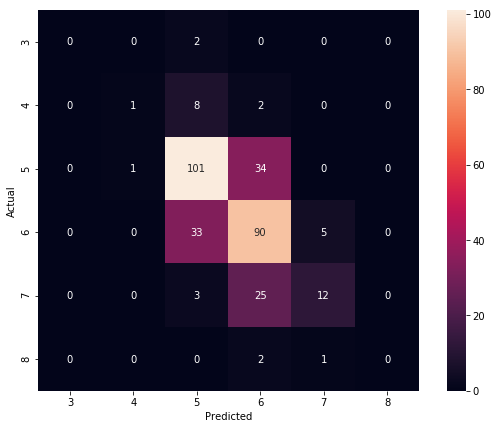

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import r2_score

y_pred_nn = 0
y_pred_nn = CV_nn.predict(X_test)
print("Actual Qualities: ")
y_test.values[0:10]
print("Predicted Qualities: ")
y_pred_nn[0:10]
print("Forced Classification: ")
y_pred_nn_int = np.rint(y_pred_nn)
y_pred_nn_int[0:10]

print("R2 score: ", r2_score(y_test, y_pred_nn))

print("Confusion Matrix: ")
cm = confusion_matrix(y_test, y_pred_nn_int)
     
df_cm = pd.DataFrame(cm, range(3,9), range(3,9))

plt.figure(figsize = (10,7));
sns.heatmap(df_cm, annot=True, fmt='d', square=True);
plt.xlabel('Predicted');
plt.ylabel('Actual');


print("Classification Scores: ")
precision, recall, fscore, support = score(y_test, y_pred_nn_int);

df_precision = pd.DataFrame(precision, index=range(3, 9), columns=["Precision"])
df_recall = pd.DataFrame(recall, index=range(3, 9), columns=["Recall"])
df_fscore = pd.DataFrame(fscore, index=range(3, 9), columns=["F Score"])
df_support = pd.DataFrame(support, index=range(3, 9), columns=["Support"])

score = pd.concat([df_precision, df_recall, df_fscore, df_support], axis = 1)
score

The last model we are going to try:

# KNeighbors

In [51]:
from sklearn.neighbors import KNeighborsRegressor

pipeline_kn = make_pipeline(
    preprocessing.StandardScaler(),
    KNeighborsRegressor()
)

hyperparameters_kn = {
    'kneighborsregressor__n_neighbors': [25, 30, 35, 50],
    'kneighborsregressor__weights': ['distance', 'uniform'],
    'kneighborsregressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

CV_kn = GridSearchCV(pipeline_kn, hyperparameters_kn,cv=3)

CV_kn.fit(X_train, y_train)

print("Best Parameters = ", CV_kn.best_params_)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kneighborsregressor__n_neighbors': [25, 30, 35, 50], 'kneighborsregressor__weights': ['distance', 'uniform'], 'kneighborsregressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Parameters =  {'kneighborsregressor__algorithm': 'auto', 'kneighborsregressor__n_neighbors': 35, 'kneighborsregressor__weights': 'distance'}


## GridSearch Results
### Run 1:
```python
hyperparameters_kn = {
    'kneighborsregressor__n_neighbors': [10,20,30],
    'kneighborsregressor__weights': ['distance', 'uniform'],
    'kneighborsregressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

Best Parameters =  {
    'kneighborsregressor__algorithm': 'auto', 
    'kneighborsregressor__n_neighbors': 30, 
    'kneighborsregressor__weights': 'distance'
}

R2 score:  0.48709930370720866
    
	Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.748252	0.786765	0.767025	136
6	0.646259	0.742188	0.690909	128
7	0.689655	0.500000	0.579710	40
8	1.000000	0.333333	0.500000	3
```

### Run 2:
```python
hyperparameters_kn = {
    'kneighborsregressor__n_neighbors': [25, 30, 35, 50],
    'kneighborsregressor__weights': ['distance', 'uniform'],
    'kneighborsregressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

Best Parameters =  {
    'kneighborsregressor__algorithm': 'auto', 
    'kneighborsregressor__n_neighbors': 35, 
    'kneighborsregressor__weights': 'distance'
}

R2 score:  0.4885513156450002

Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.734694	0.794118	0.763251	136
6	0.647887	0.718750	0.681481	128
7	0.700000	0.525000	0.600000	40
8	1.000000	0.333333	0.500000	3
```

## Final Model

In [52]:
CV_kn = make_pipeline(
    preprocessing.StandardScaler(),
    KNeighborsRegressor(
        algorithm = 'auto',
        n_neighbors = 35,
        weights = 'distance'
    )
)

CV_kn.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=35, p=2,
          weights='distance'))])

## Performance

Actual Qualities: 


array([6, 5, 6, 5, 6, 6, 6, 6, 7, 7], dtype=int64)

Predicted Qualities: 


array([5.41, 5.00, 6.35, 5.05, 5.50, 6.00, 5.83, 5.60, 7.00, 6.69])

Forced Classification: 


array([5.00, 5.00, 6.00, 5.00, 5.00, 6.00, 6.00, 6.00, 7.00, 7.00])

R2 score:  0.4885513156450002
Forced Classification Scores:


Text(0.5,42,'Predicted')

Text(134.88,0.5,'Actual')

,Precision,Recall,F Score,Support
3,0.000000,0.000000,0.000000,2
4,0.000000,0.000000,0.000000,11
5,0.734694,0.794118,0.763251,136
6,0.647887,0.718750,0.681481,128
7,0.700000,0.525000,0.600000,40
8,1.000000,0.333333,0.500000,3


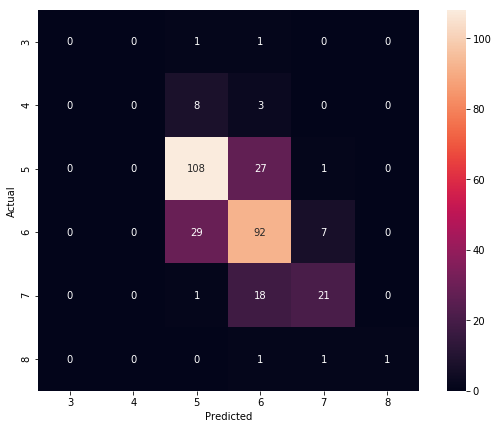

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import r2_score

y_pred_kn = 0
y_pred_kn = CV_kn.predict(X_test)
print("Actual Qualities: ")
y_test.values[0:10]
print("Predicted Qualities: ")
y_pred_kn[0:10]
print("Forced Classification: ")
y_pred_kn_int = np.rint(y_pred_kn)
y_pred_kn_int[0:10]

print("R2 score: ", r2_score(y_test, y_pred_kn))
print("Forced Classification Scores:")

cm = confusion_matrix(y_test, y_pred_kn_int)
     
df_cm = pd.DataFrame(cm, range(3,9), range(3,9))
plt.figure(figsize = (10,7))


sns.heatmap(df_cm, annot=True, fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')


precision, recall, fscore, support = score(y_test, y_pred_kn_int)

df_precision = pd.DataFrame(precision, index=range(3, 9), columns=["Precision"])
df_recall = pd.DataFrame(recall, index=range(3, 9), columns=["Recall"])
df_fscore = pd.DataFrame(fscore, index=range(3, 9), columns=["F Score"])
df_support = pd.DataFrame(support, index=range(3, 9), columns=["Support"])

score = pd.concat([df_precision, df_recall, df_fscore, df_support], axis = 1)
score

Let us try a classifier, just for fun:

# Random Forest Classifier
## Cross Validation with Gridsearch

In [54]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rfc = make_pipeline(
    preprocessing.StandardScaler(), 
    RandomForestClassifier()
)

hyperparameters_rfc = { 
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth': [3000, 3500, 4000],
    'randomforestclassifier__n_estimators': [200, 300, 500]
}

CV_rfc = GridSearchCV(pipeline_rfc, hyperparameters_rfc, cv=3)

CV_rfc.fit(X_train, y_train)
print("Best Parameters = ", CV_rfc.best_params_)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'], 'randomforestclassifier__max_depth': [3000, 3500, 4000], 'randomforestclassifier__n_estimators': [200, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best Parameters =  {'randomforestclassifier__max_depth': 4000, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 500}


## Grid Search Results:
### Run 1: 
```python
hyperparameters_rfc = { 
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth': [3000, 5000, None],
    'randomforestclassifier__n_estimators': [200, 500, 1000]
}

Best Parameters =  {
    'randomforestclassifier__max_depth': 3000, 
    'randomforestclassifier__max_features': 'sqrt', 
    'randomforestclassifier__n_estimators': 500
}

	Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.746667	0.823529	0.783217	136
6	0.691729	0.718750	0.704981	128
7	0.657143	0.575000	0.613333	40
8	1.000000	0.333333	0.500000	3
```

### Run 2:
```python
hyperparameters_rfc = { 
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth': [3000, 3500, 4000],
    'randomforestclassifier__n_estimators': [200, 300, 500]
}

Best Parameters =  {
    'randomforestclassifier__max_depth': 4000, 
    'randomforestclassifier__max_features': 'log2', 
    'randomforestclassifier__n_estimators': 500
}

	Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.741722	0.823529	0.780488	136
6	0.691729	0.718750	0.704981	128
7	0.647059	0.550000	0.594595	40
8	1.000000	0.333333	0.500000	3
```
### Run 3:
```python
hyperparameters_rfc = { 
    'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth': [1500, 3000, None],
    'randomforestclassifier__n_estimators': [100, 150, 200]
}

Best Parameters =  {
    'randomforestclassifier__max_depth': 3000, 
    'randomforestclassifier__max_features': 'sqrt', 
    'randomforestclassifier__n_estimators': 200
}

Precision	Recall	F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.740000	0.816176	0.776224	136
6	0.696970	0.718750	0.707692	128
7	0.666667	0.600000	0.631579	40
8	1.000000	0.333333	0.500000	3
```

It looks like performance is maxed out already.

## Final Model:

In [55]:
CV_rfc = RandomForestClassifier(
    max_depth = 3000, 
    max_features = 'sqrt', 
    n_estimators = 200
)
CV_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3000, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Performance
#### Confusion Matrix:

Actual Qualities: 


array([6, 5, 6, 5, 6, 6, 6, 6, 7, 7], dtype=int64)

Predicted Qualities: 


array([5, 5, 6, 5, 6, 6, 6, 6, 7, 7], dtype=int64)

Classification Scores:


Text(0.5,42,'Predicted')

Text(134.88,0.5,'Actual')

,Precision,Recall,F Score,Support
3,0.000000,0.000000,0.000000,2
4,0.000000,0.000000,0.000000,11
5,0.733333,0.808824,0.769231,136
6,0.686567,0.718750,0.702290,128
7,0.676471,0.575000,0.621622,40
8,1.000000,0.333333,0.500000,3


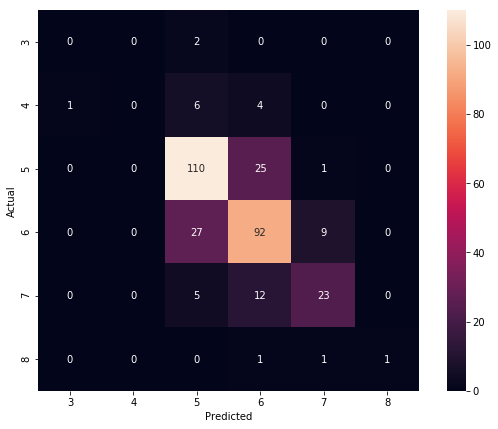

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

y_pred_rfc = 0
y_pred_rfc = CV_rfc.predict(X_test)
print("Actual Qualities: ")
y_test.values[0:10]
print("Predicted Qualities: ")
y_pred_rfc[0:10]

print("Classification Scores:")

cm = confusion_matrix(y_test, y_pred_rfc)
     
df_cm = pd.DataFrame(cm, range(3,9), range(3,9))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')


precision, recall, fscore, support = score(y_test, y_pred_rfc);

df_precision = pd.DataFrame(precision, index=range(3, 9), columns=["Precision"])
df_recall = pd.DataFrame(recall, index=range(3, 9), columns=["Recall"])
df_fscore = pd.DataFrame(fscore, index=range(3, 9), columns=["F Score"])
df_support = pd.DataFrame(support, index=range(3, 9), columns=["Support"])

score = pd.concat([df_precision, df_recall, df_fscore, df_support], axis = 1)
score

# A Comparison Between Random Forest Regressor and Classifier
```python
Classifier:
     Precision   Recall      F Score     Support
3    0.000000    0.000000    0.000000    2
4    0.000000    0.000000    0.000000    11
5    0.740000    0.816176    0.776224    136
6    0.696970    0.718750    0.707692    128
7    0.666667    0.600000    0.631579    40
8    1.000000    0.333333    0.500000    3

Regressor:

    Precision	Recall	    F Score	    Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.726667	0.801471	0.762238	136
6	0.678322	0.757812	0.715867	128
7	0.740741	0.500000	0.597015	40
8	0.000000	0.000000	0.000000	3
```

Very surprisingly, the classifier performs better than the regressor on our dataset, which is weird considering that the classifier treats falsely predicting a quality of 4 as bad/good as falsely predicting a quality of 8 when the actual quality is 3.

I believe that if we had more and higher quality data, the regressor will learn to perform better than the classifier as it takes in the fact that predicting a 4 for a 3 is better than predicting 8 for a 3.

After comparing precision and recall scores of different models, we agree upon a best model

# Best Model:

In [57]:
rfr = make_pipeline(
    preprocessing.StandardScaler(),
    RandomForestRegressor(
        max_features = 'sqrt',
        n_estimators = 1500,
        min_samples_split = 2
    )
)

rfr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

Its performance:
```python
R2 score:  0.5376639543690431

    Precision	Recall	 F Score	Support
3	0.000000	0.000000	0.000000	2
4	0.000000	0.000000	0.000000	11
5	0.726667	0.801471	0.762238	136
6	0.678322	0.757812	0.715867	128
7	0.740741	0.500000	0.597015	40
8	0.000000	0.000000	0.000000	3
```

# Saving the Trained Model

In [58]:
joblib.dump(rfr, 'rf_regressor.pkl')
# To load: rfr2 = joblib.load('rf_regressor.pkl')

['rf_regressor.pkl']

# Conclusion

Although the data collected was not very good, the features didn't correlate much at all with the quality. However, we were able to achieve satisfactory results with all models, most notibly the Random Forest Regressor with a high recall of 0.8 on the most frequent quality: 5. 

Due to the nature of multiclass classification, a ROC curve was not used to evaluate the models. Rather, we identified the best model to use by inspecting the precision, recall and f scores. 

That concludes this notebook, thanks for reading